In [1]:
import warnings
warnings.filterwarnings('ignore')

# MODEL BERT MULTILINGUAL

Import Library

In [2]:
import pandas as pd
import random
import json
import torch
import shutil
import os
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForQuestionAnswering, TrainingArguments, Trainer, pipeline
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

Mengecek Max Length

In [3]:
# Load dataset
data_files = {
    "train": "/kaggle/input/qna-dataset-sejarah-indonesia/train_sejarah.json",
    "validation": "/kaggle/input/qna-dataset-sejarah-indonesia/val_sejarah.json",
    "test": "/kaggle/input/qna-dataset-sejarah-indonesia/test_sejarah.json"
}
dataset = load_dataset("json", data_files=data_files)

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")

# Function to calculate the maximum length of the dataset
def calculate_max_length(dataset, tokenizer):
    max_len = 0
    for example in dataset:
        question = example["qas"][0]["question"]
        context = example["context"]
        # Combine question and context and tokenize
        input_text = question + " " + context
        # Get tokenized length (length of tokens after tokenization)
        input_len = len(tokenizer.encode(input_text, truncation=False))
        max_len = max(max_len, input_len)
    return max_len

# Calculate max length for training, validation, and test datasets
max_train_length = calculate_max_length(dataset["train"], tokenizer)
max_val_length = calculate_max_length(dataset["validation"], tokenizer)
max_test_length = calculate_max_length(dataset["test"], tokenizer)

# Take the max of all three datasets
max_length = max(max_train_length, max_val_length, max_test_length)

print(f"Max length for train dataset: {max_train_length}")
print(f"Max length for validation dataset: {max_val_length}")
print(f"Max length for test dataset: {max_test_length}")
print(f"Overall max length: {max_length}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Max length for train dataset: 90
Max length for validation dataset: 94
Max length for test dataset: 73
Overall max length: 94


In [4]:
# Load dataset
data_files = {
    "train": "/kaggle/input/qna-dataset-sejarah-indonesia/train_sejarah.json",
    "validation": "/kaggle/input/qna-dataset-sejarah-indonesia/val_sejarah.json"
}
dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [5]:
# Load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")
model = BertForQuestionAnswering.from_pretrained("bert-base-multilingual-cased")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Preprocessing function
def preprocess_function(examples):
    inputs = tokenizer(
        examples["qas"][0]["question"],
        examples["context"],
        max_length=128,
        truncation=True,
        padding="max_length",
        return_offsets_mapping=True,
    )
    start_char = examples["qas"][0]["answers"][0]["answer_start"]
    end_char = start_char + len(examples["qas"][0]["answers"][0]["text"])

    # Find token positions for the answer
    offset_mapping = inputs.pop("offset_mapping")
    start_token = end_token = 0
    for idx, (start, end) in enumerate(offset_mapping):
        if start <= start_char < end:
            start_token = idx
        if start < end_char <= end:
            end_token = idx
            break

    inputs["start_positions"] = start_token
    inputs["end_positions"] = end_token
    return inputs

In [7]:
# Tokenize datasets
tokenized_train = dataset["train"].map(preprocess_function, remove_columns=dataset["train"].column_names)
tokenized_val = dataset["validation"].map(preprocess_function, remove_columns=dataset["validation"].column_names)

Map:   0%|          | 0/1701 [00:00<?, ? examples/s]

Map:   0%|          | 0/364 [00:00<?, ? examples/s]

In [8]:
# Compute metrics function 
def compute_metrics(eval_pred):
    predictions, labels = eval_pred  # predictions: tuple, labels: tuple
    start_preds, end_preds = np.argmax(predictions[0], axis=1), np.argmax(predictions[1], axis=1)
    
    # Decode predictions and labels to strings
    predicted_answers = []
    true_answers = []

    for i in range(len(start_preds)):
        # Decode predicted answers
        pred_tokens = tokenizer.convert_ids_to_tokens(
            tokenized_val[i]["input_ids"][start_preds[i]:end_preds[i] + 1]
        )
        predicted_answers.append(tokenizer.convert_tokens_to_string(pred_tokens))

        # Decode true answers
        start_char = dataset["validation"][i]["qas"][0]["answers"][0]["answer_start"]
        end_char = start_char + len(dataset["validation"][i]["qas"][0]["answers"][0]["text"])
        true_answer = dataset["validation"][i]["context"][start_char:end_char]
        true_answers.append(true_answer)

    # Compute Exact Match and F1
    em_scores = []
    f1_scores = []

    for pred, true in zip(predicted_answers, true_answers):
        # Exact Match
        em_scores.append(int(pred.strip() == true.strip()))

        # F1 Score
        pred_tokens = pred.split()
        true_tokens = true.split()
        common_tokens = set(pred_tokens) & set(true_tokens)

        if len(common_tokens) == 0:
            f1_scores.append(0)
        else:
            precision = len(common_tokens) / len(pred_tokens)
            recall = len(common_tokens) / len(true_tokens)
            f1_scores.append(2 * (precision * recall) / (precision + recall))

    # Calculate mean scores
    em = np.mean(em_scores)
    f1 = np.mean(f1_scores)

    return {"EM": em, "F1": f1}

In [9]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.02,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1
)

In [10]:
# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [11]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Em,F1
1,0.672500,0.541260,0.760989,0.877021
2,0.546200,0.482705,0.760989,0.880213
3,0.639100,0.467335,0.755495,0.875401
4,0.377100,0.507614,0.774725,0.880608
5,0.295900,0.511154,0.766484,0.878780
6,0.232300,0.537487,0.769231,0.877284
7,0.187900,0.567584,0.766484,0.872368
8,0.186100,0.576821,0.771978,0.880887


TrainOutput(global_step=856, training_loss=0.4398745867972062, metrics={'train_runtime': 412.3319, 'train_samples_per_second': 33.003, 'train_steps_per_second': 2.076, 'total_flos': 888931566415872.0, 'train_loss': 0.4398745867972062, 'epoch': 8.0})

Hasil Evaluasi BERT Multilingual

In [12]:
# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'eval_loss': 0.467335045337677, 'eval_EM': 0.7554945054945055, 'eval_F1': 0.8754009260587617, 'eval_runtime': 2.3532, 'eval_samples_per_second': 154.681, 'eval_steps_per_second': 5.099, 'epoch': 8.0}


Visualisasi Train dan Validation Loss BERT Multilingual

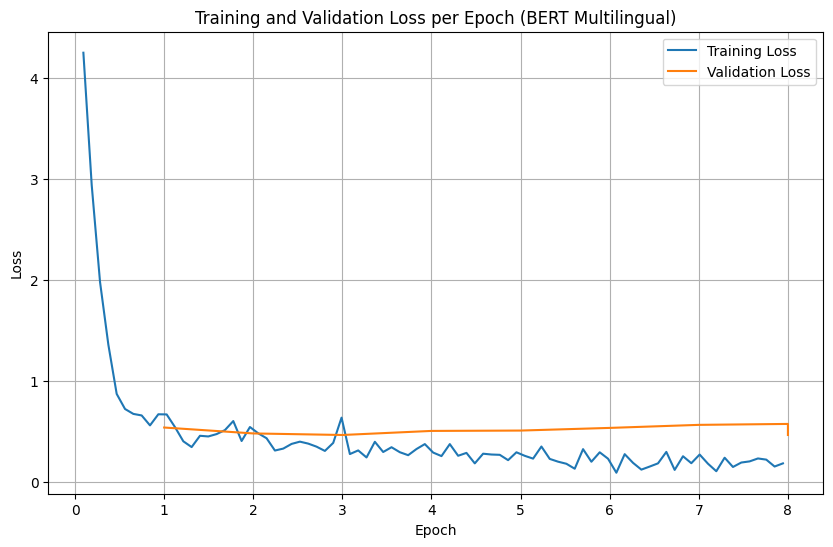

In [13]:
# Plot training and validation loss
log_history = trainer.state.log_history
logs = pd.DataFrame(log_history)
train_logs = logs[logs["loss"].notnull()]
eval_logs = logs[logs["eval_loss"].notnull()]

plt.figure(figsize=(10, 6))
plt.plot(train_logs["epoch"], train_logs["loss"], label="Training Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss")

# Customizing y-axis ticks
plt.yticks([0, 1, 2, 3, 4])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch (BERT Multilingual)")
plt.legend()
plt.grid(True)
plt.show()


Membuat Prediksi

In [14]:
# Prediction function
def predict(question, context):
    inputs = tokenizer(question, context, max_length=128, truncation=True, padding=True, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

    # Find the tokens with the highest start and end scores
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)

    # Decode the answer
    answer = tokenizer.decode(inputs["input_ids"][0][start_idx:end_idx + 1])
    return answer

# Test prediction
context = "motivasi rakyat sumatra selatan untuk melawan belanda adalah mereka ingin mempertahankan kebebasan dari cengkeraman belanda"
question = "apa yang memotivasi rakyat sumatra selatan untuk melawan belanda?"
print("Predicted Answer:", predict(question, context))

Predicted Answer: mereka ingin mempertahankan kebebasan dari cengkeraman belanda


In [15]:
# Test prediction
context = "Indonesia merdeka pada tanggal 17 Agustus 1945"
question = "Kapan indonesia merdeka?"
print("Predicted Answer:", predict(question, context))

Predicted Answer: 17 Agustus 1945


In [16]:
# Test prediction
context = "Agama Hindu masuk ke Nusantara sekitar abad pertama"
question = "Kapan agama Hindu masuk ke Nusantara?"
print("Predicted Answer:", predict(question, context))

Predicted Answer: sekitar abad pertama


In [17]:
# Test prediction
context = "Candi pada masa Hindu Buddha digunakan untuk tempat pemujaan dewa atau Buddha"
question = "Apa fungsi candi pada masa Hindu Buddha?"
print("Predicted Answer:", predict(question, context))

Predicted Answer: tempat pemujaan dewa atau Buddha


Prediksi Untuk Data Test

In [22]:
# Load the Question Answering pipeline with the model and tokenizer
qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)

# Load test dataset
test_data_file = "/kaggle/input/qna-dataset-sejarah-indonesia/test_sejarah.json"
dataset = load_dataset("json", data_files={"test": test_data_file})

# Prepare data for predictions
predictions = []
for example in dataset["test"]:
    question = example["qas"][0]["question"]
    context = example["context"]
    true_answer = example["qas"][0]["answers"][0]["text"]

    # Use pipeline for prediction
    result = qa_pipeline(question=question, context=context)
    predicted_answer = result['answer']

    # Append prediction data
    predictions.append({
        "question": question,
        "context": context,
        "answer": true_answer,
        "predicted_answer": predicted_answer
    })

# Convert predictions to DataFrame and save as CSV
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv("/kaggle/working/predictions_sejarah_bert.csv", index=False)

print("Predictions saved to 'predictions_sejarah_bert.csv'.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Generating test split: 0 examples [00:00, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Predictions saved to 'predictions_sejarah_bert.csv'.


In [23]:
predictions_df

,question,context,answer,predicted_answer
0,apa yang dilakukan jepang terhadap tempat temp...,tempat tempat ibadah yang dinilai mendukung pe...,diawasi ketat atau bahkan ditutup,diawasi ketat atau bahkan ditutup
1,apa kontribusi sutan sjahrir dalam memperjuang...,kontribusi sutan sjahrir dalam memperjuangkan ...,aktif menyebarkan pemikiran demokrasi dan anti...,aktif menyebarkan pemikiran demokrasi dan anti...
2,apa kebijakan ekonomi yang diterapkan untuk me...,kebijakan ekonomi yang diterapkan untuk mengat...,restrukturisasi utang dan deregulasi ekonomi,restrukturisasi utang dan deregulasi ekonomi
3,apa yang dilakukan portugis untuk mendapatkan ...,yang dilakukan portugis untuk mendapatkan duku...,menjalin perjanjian dengan kerajaan lokal untu...,dengan menjalin perjanjian dengan kerajaan lok...
4,apa alasan jepang menghapuskan bahasa belanda ...,alasan jepang menghapuskan bahasa belanda dari...,mengurangi pengaruh kolonialisme barat di indo...,mengurangi pengaruh kolonialisme barat di indo...
...,...,...,...,...
360,apa yang terjadi dengan kondisi sosial masyara...,kondisi sosial masyarakat saat masa sistem tan...,terganggu akibat eksploitasi kerja paksa,menjadi terganggu akibat eksploitasi kerja paksa
361,apa yang dimaksud dengan perlawanan pasif?,perlawanan pasif adalah bentuk perlawanan tanp...,bentuk perlawanan tanpa kekerasan seperti misa...,bentuk perlawanan tanpa kekerasan seperti misa...
362,siapa yang menjadi pemimpin umat islam di indo...,pemimpin umat islam di indonesia terdiri dari ...,"berbagai organisasi, seperti nu dan muhammadiyah","berbagai organisasi, seperti nu dan muhammadiyah"
363,bagaimana belanda melindungi monopoli perdagan...,belanda melindungi monopoli perdagangan rempah...,mengontrol jalur laut dan membangun benteng,mengontrol jalur laut dan membangun benteng


Hasil Evaluasi Data Test Menggunakan Model BERT Multilingual

In [24]:
# Compute EM and F1 for test set
def compute_em_f1(predictions_df):
    em_scores = []
    f1_scores = []

    for _, row in predictions_df.iterrows():
        true_answer = row["answer"]
        predicted_answer = row["predicted_answer"]

        # Exact Match
        em_scores.append(int(true_answer.strip() == predicted_answer.strip()))

        # F1 Score
        true_tokens = true_answer.split()
        pred_tokens = predicted_answer.split()
        common_tokens = set(true_tokens) & set(pred_tokens)

        if len(common_tokens) == 0:
            f1_scores.append(0)
        else:
            precision = len(common_tokens) / len(pred_tokens)
            recall = len(common_tokens) / len(true_tokens)
            f1_scores.append(2 * (precision * recall) / (precision + recall))

    em_score = np.mean(em_scores) * 100
    f1_score = np.mean(f1_scores) * 100

    return em_score, f1_score

em, f1 = compute_em_f1(predictions_df)
print(f"Test Exact Match (EM) Score: {em:.2f}%")
print(f"Test F1 Score: {f1:.2f}%")

Test Exact Match (EM) Score: 57.26%
Test F1 Score: 83.39%


Menyimpan Model BERT

In [25]:
# Tentukan path checkpoint dan path tujuan zip file
checkpoint_dir = '/kaggle/working/results/checkpoint-321'
zip_file_path = '/kaggle/working/results/checkpoint-321'

# Membuat ZIP dari direktori checkpoint
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', checkpoint_dir)

print(f"Checkpoint model berhasil disimpan di: {zip_file_path}")

Checkpoint model berhasil disimpan di: /kaggle/working/results/checkpoint-321
